Epoch 1/10
37/37 [==============================] - 5s 53ms/step - loss: 0.0140 - val_loss: 0.0047
Epoch 2/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 0.0012 - val_loss: 6.5693e-04
Epoch 4/10
37/37 [==============================] - 1s 39ms/step - loss: 0.0011 - val_loss: 8.3099e-04
Epoch 5/10
37/37 [==============================] - 1s 39ms/step - loss: 8.9452e-04 - val_loss: 0.0012
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 9.9750e-04 - val_loss: 9.3047e-04
Epoch 7/10
37/37 [==============================] - 2s 42ms/step - loss: 9.4891e-04 - val_loss: 8.9046e-04
Epoch 8/10
37/37 [==============================] - 1s 40ms/step - loss: 9.5128e-04 - val_loss: 7.4491e-04
Epoch 9/10
37/37 [==============================] - 1s 38ms/step - loss: 8.6127e-04 - val_loss: 0.0014
Epoch 10/10
19/19 [==============================] - 1s 12ms/step
MSE

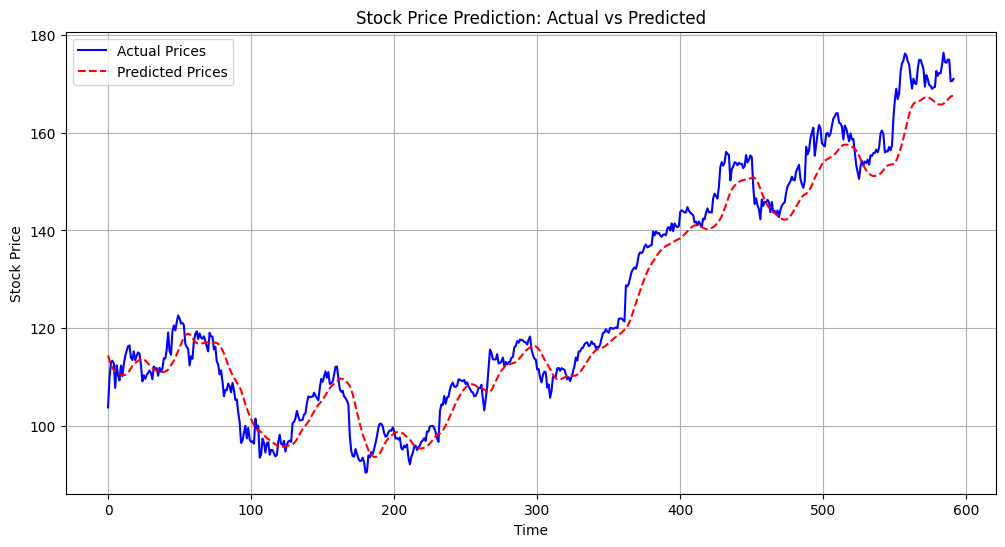

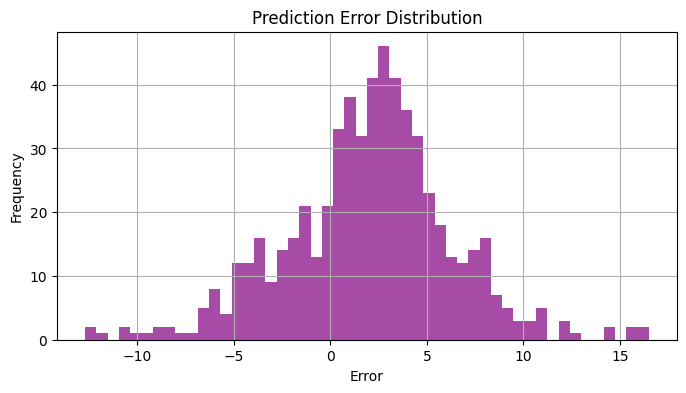

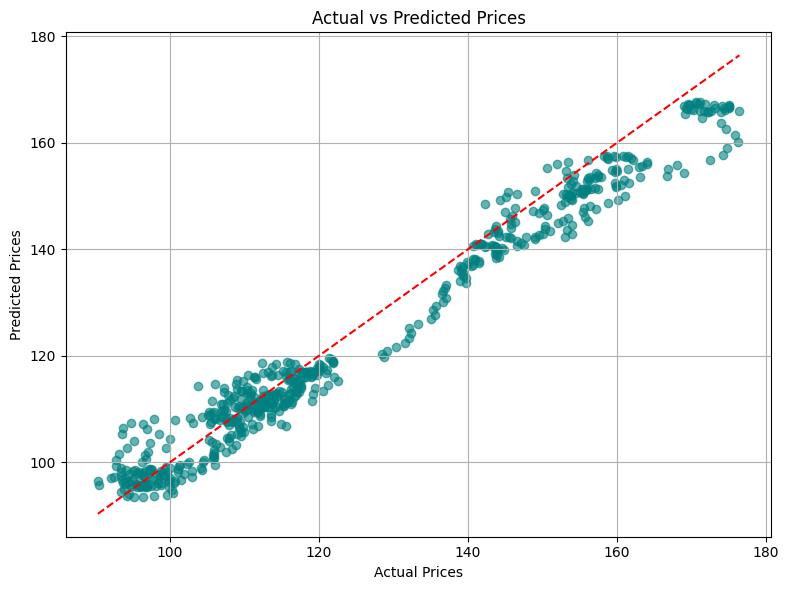

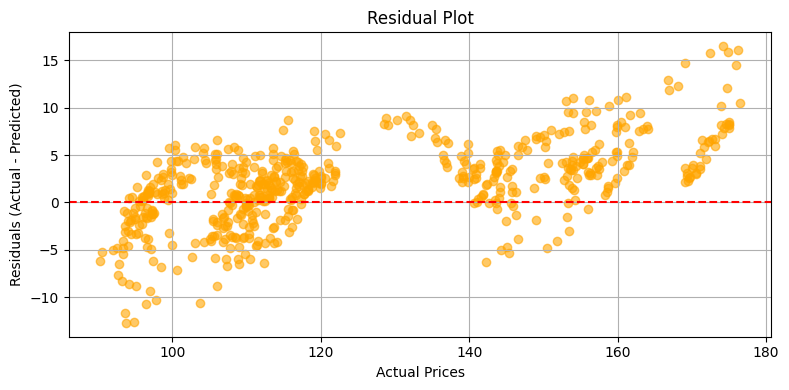

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Load and preprocess data
df = pd.read_csv('AAPL.csv')  # Ensure 'Close' column exists
prices = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# 2. Create time series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_prices, SEQ_LENGTH)

# 3. Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4. Build and train LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# 5. Make predictions and inverse transform
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. Performance metrics
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}%")

# 7. Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red', linestyle='--')
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# 8. Plot prediction error distribution
plt.figure(figsize=(8, 4))
plt.hist(y_test_actual - predictions, bins=50, color='purple', alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 9. Scatter plot: Actual vs Predicted (regression alternative to confusion matrix)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, predictions, color='teal', alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Residual plot
residuals = y_test_actual - predictions

plt.figure(figsize=(8, 4))
plt.scatter(y_test_actual, residuals, color='orange', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()
